In [1]:
import pandas as pd
import numpy as np
import os
import gc
import datetime as dt
import warnings

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
p = matplotlib.rcParams
p["font.size"] = 20
p["axes.unicode_minus"] = False
p['lines.linewidth'] = 3
p['pdf.fonttype'] = 42
p['ps.fonttype'] = 42
p["figure.figsize"] = [12, 8]
p['grid.color'] = 'k'
p['grid.linestyle'] = ':'
p['grid.linewidth'] = 0.5
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 5))  
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.neural_network import MLPRegressor,MLPClassifier
from xgboost import XGBClassifier, XGBRegressor

from sklearn.linear_model import LassoCV,Lasso
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing

from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import plot_partial_dependence
from alibi.explainers import ALE, plot_ale, AnchorTabular

import warnings 
warnings.filterwarnings('ignore')

import alibi
import shap
from sklearn_gbmi import *

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
def binary_class(df):
    return(pd.qcut(df,2,labels=False))   
def multi_class(df):
    return(pd.qcut(df,10,labels=False))
    
train['binary_class'] = train.groupby(['datadate'])['forward_excess_ret'].transform(binary_class)
train.dropna(subset=['forward_excess_ret'],inplace=True)
train['multi_class'] = train.groupby(['datadate'])['forward_excess_ret'].transform(multi_class)
test['binary_class'] = test.groupby(['datadate'])['forward_excess_ret'].transform(binary_class)
test.dropna(subset=['forward_excess_ret'],inplace=True)
test['multi_class'] = test.groupby(['datadate'])['forward_excess_ret'].transform(multi_class)

feature_names=['MA3','MA12','Size','ROI','PS','ev_ebitda','earningsVol','dividend_yield','epspi12']

In [16]:
X_train = train[feature_names]
y_train = train['forward_excess_ret']
X_test = test[feature_names]
y_test = test['forward_excess_ret']

In [4]:
linear = LinearRegression().fit(X_train,y_train)
lasso = LassoCV(cv=5,fit_intercept=True,alphas=np.linspace(0.00001,0.001,100)).fit(X_train,y_train) 
DT = DecisionTreeRegressor(max_depth=5,random_state=0).fit(X_train,y_train)
knn = KNeighborsRegressor(n_neighbors=20).fit(X_train,y_train)
rf = RandomForestRegressor(max_depth=10).fit(X_train,y_train)
ada = AdaBoostRegressor(random_state=0, n_estimators=100).fit(X_train,y_train)
xg = XGBRegressor(max_depth=10).fit(X_train,y_train)
gb = GradientBoostingRegressor(random_state=0, n_estimators=100).fit(X_train,y_train)
mlp = MLPRegressor(solver='lbfgs', alpha=0.01,hidden_layer_sizes=(15,3), random_state=1).fit(X_train,y_train)

[16:25:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [37]:
def metrics(model):  
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    scores = cross_val_score(model, X_train,y_train, cv=5)
    print('Train')
    print('CV score: %f'%np.mean(scores))
    print('MSE: %f '%mse(y_train, train_pred))
    print('-----------------------------------------')
    
    scores = cross_val_score(model, X_test,y_test, cv=5)
    print('Test')
    print('CV score: %f'%np.mean(scores))
    print('MSE: %f'%mse(y_test, test_pred))
    print('-----------------------------------------')

In [33]:
metrics(linear)

Train
CV score: -0.004996
MSE: 0.004583 
-----------------------------------------
Test
CV score: -0.021173
MSE: 0.002618


In [38]:
for n in [2,5,10,20]:
    rf = RandomForestRegressor(max_depth=n).fit(X_train,y_train)
    print(n,':')
    metrics(rf)

2 :
Train
CV score: -0.003685
MSE: 0.004556 
-----------------------------------------
Test
CV score: 0.033939
MSE: 0.002627
-----------------------------------------
5 :
Train
CV score: -0.007448
MSE: 0.004434 
-----------------------------------------
Test
CV score: 0.003448
MSE: 0.002664
-----------------------------------------
10 :
Train
CV score: -0.015587
MSE: 0.003972 
-----------------------------------------
Test
CV score: 0.000235
MSE: 0.002725
-----------------------------------------
20 :
Train
CV score: -0.033187
MSE: 0.002462 
-----------------------------------------
Test
CV score: -0.006815
MSE: 0.002806
-----------------------------------------


## PDP

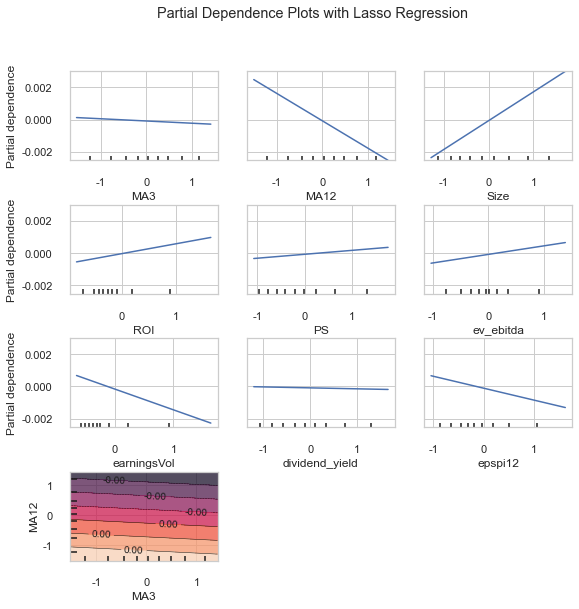

In [9]:
from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import plot_partial_dependence
from matplotlib import pyplot as plt

features = list(range(len(feature_names)))
features.append((0,1))

plot_partial_dependence(linear, X_train, features, feature_names=feature_names) 
fig = plt.gcf()
fig.set_size_inches(9, 9) 

fig.suptitle('Partial Dependence Plots with Lasso Regression')
fig.subplots_adjust(hspace=0.5)

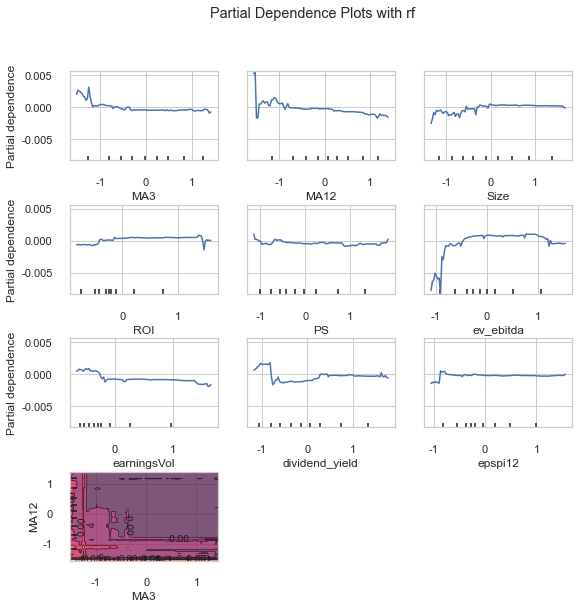

In [17]:
###########XGBOOSTING################ 不能跑PDP
features = list(range(len(feature_names)))
features.append((0,1))

plot_partial_dependence(rf.fit(X_train,y_train), X_test, features, feature_names=feature_names) 
fig = plt.gcf()
fig.set_size_inches(9, 9) 
fig.suptitle('Partial Dependence Plots with rf')
fig.subplots_adjust(hspace=0.5)

## ALE

In [ ]:
#### XGBoosting####### 跑不了

ALE for Linear Regression:


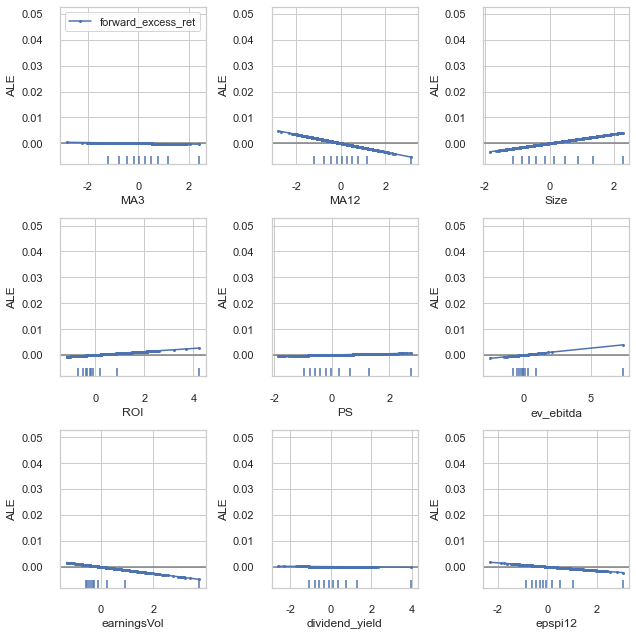

ALE for Random Forest:


array([[<AxesSubplot:xlabel='MA3', ylabel='ALE'>,
        <AxesSubplot:xlabel='MA12', ylabel='ALE'>,
        <AxesSubplot:xlabel='Size', ylabel='ALE'>],
       [<AxesSubplot:xlabel='ROI', ylabel='ALE'>,
        <AxesSubplot:xlabel='PS', ylabel='ALE'>,
        <AxesSubplot:xlabel='ev_ebitda', ylabel='ALE'>],
       [<AxesSubplot:xlabel='earningsVol', ylabel='ALE'>,
        <AxesSubplot:xlabel='dividend_yield', ylabel='ALE'>,
        <AxesSubplot:xlabel='epspi12', ylabel='ALE'>]], dtype=object)

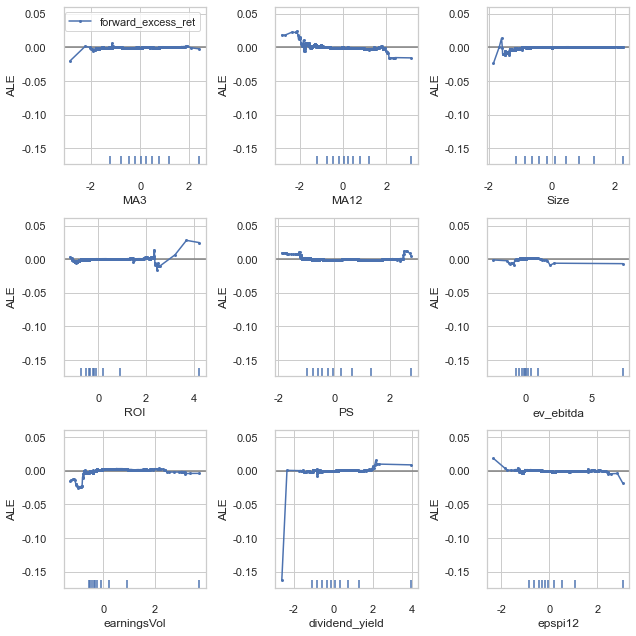

In [10]:
from alibi.explainers import ALE, plot_ale, AnchorTabular
ale_lr = ALE(linear.predict, feature_names=feature_names, target_names = ['forward_excess_ret'])
exp_lr = ale_lr.explain(X_train.values)
print('ALE for Linear Regression:')
plot_ale(exp_lr, fig_kw={'figwidth':9, 'figheight': 9})
plt.show()

print('ALE for Random Forest:')
ale_rf = ALE(rf.predict, feature_names=feature_names, target_names = ['forward_excess_ret'])
exp_rf = ale_rf.explain(X_train.values)
plot_ale(exp_rf, fig_kw={'figwidth':9, 'figheight': 9})

## H stats

In [23]:
d = h_all_pairs(gb, X_train)
l=sorted(d.items(), key=lambda x: x[1],reverse=True)
l[:10]

[(('ROI', 'dividend_yield'), 0.39980891026834325),
 (('MA3', 'earningsVol'), 0.35793092843768315),
 (('earningsVol', 'dividend_yield'), 0.31547111982386006),
 (('dividend_yield', 'epspi12'), 0.3077338049504149),
 (('MA12', 'ROI'), 0.291830219897351),
 (('ev_ebitda', 'epspi12'), 0.2639874172349054),
 (('MA3', 'epspi12'), 0.26193046653341423),
 (('Size', 'earningsVol'), 0.2573870699319409),
 (('MA3', 'Size'), 0.25264312221874696),
 (('MA3', 'ROI'), 0.22236485278023504)]

In [6]:
import pdpbox
import itertools 
import math
from pdpbox.pdp_calc_utils import _calc_ice_lines_inter
from pdpbox.pdp import pdp_isolate, PDPInteract
from pdpbox.utils import (_check_model, _check_dataset, _check_percentile_range, _check_feature,
                    _check_grid_type, _check_memory_limit, _make_list,
                    _calc_memory_usage, _get_grids, _get_grid_combos, _check_classes)
from joblib import Parallel, delayed

def pdp_multi_interact(model, dataset, model_features, features, 
                    num_grid_points=None, grid_types=None, percentile_ranges=None, grid_ranges=None, cust_grid_points=None, 
                    cust_grid_combos=None, use_custom_grid_combos=False,
                    memory_limit=0.5, n_jobs=1, predict_kwds=None, data_transformer=None):

    def _expand_default(x, default, length):
        if x is None:
            return [default] * length
        return x

    def _get_grid_combos(feature_grids, feature_types):
        grids = [list(feature_grid) for feature_grid in feature_grids]
        for i in range(len(feature_types)):
            if feature_types[i] == 'onehot':
                grids[i] = np.eye(len(grids[i])).astype(int).tolist()
        return np.stack(np.meshgrid(*grids), -1).reshape(-1, len(grids))

    if predict_kwds is None:
        predict_kwds = dict()

    nr_feats = len(features)

    # check function inputs
    n_classes, predict = _check_model(model=model)
    _check_dataset(df=dataset)
    _dataset = dataset.copy()

    # prepare the grid
    pdp_isolate_outs = []
    if use_custom_grid_combos:
        grid_combos = cust_grid_combos
        feature_grids = []
        feature_types = []
    else:
        num_grid_points = _expand_default(x=num_grid_points, default=10, length=nr_feats)
        grid_types = _expand_default(x=grid_types, default='percentile', length=nr_feats)
        for i in range(nr_feats):
            _check_grid_type(grid_type=grid_types[i])

        percentile_ranges = _expand_default(x=percentile_ranges, default=None, length=nr_feats)
        for i in range(nr_feats):
            _check_percentile_range(percentile_range=percentile_ranges[i])

        grid_ranges = _expand_default(x=grid_ranges, default=None, length=nr_feats)
        cust_grid_points = _expand_default(x=cust_grid_points, default=None, length=nr_feats)

        _check_memory_limit(memory_limit=memory_limit)

        pdp_isolate_outs = []
        for idx in range(nr_feats):
            pdp_isolate_out = pdp_isolate(
                model=model, dataset=_dataset, model_features=model_features, feature=features[idx],
                num_grid_points=num_grid_points[idx], grid_type=grid_types[idx], percentile_range=percentile_ranges[idx],
                grid_range=grid_ranges[idx], cust_grid_points=cust_grid_points[idx], memory_limit=memory_limit,
                n_jobs=n_jobs, predict_kwds=predict_kwds, data_transformer=data_transformer)
            pdp_isolate_outs.append(pdp_isolate_out)

        if n_classes > 2:
            feature_grids = [pdp_isolate_outs[i][0].feature_grids for i in range(nr_feats)]
            feature_types = [pdp_isolate_outs[i][0].feature_type  for i in range(nr_feats)]
        else:
            feature_grids = [pdp_isolate_outs[i].feature_grids for i in range(nr_feats)]
            feature_types = [pdp_isolate_outs[i].feature_type  for i in range(nr_feats)]

        grid_combos = _get_grid_combos(feature_grids, feature_types)

    feature_list = []
    for i in range(nr_feats):
        feature_list.extend(_make_list(features[i]))

    # Parallel calculate ICE lines
    true_n_jobs = _calc_memory_usage(
        df=_dataset, total_units=len(grid_combos), n_jobs=n_jobs, memory_limit=memory_limit)

    grid_results = Parallel(n_jobs=true_n_jobs)(delayed(_calc_ice_lines_inter)(
        grid_combo, data=_dataset, model=model, model_features=model_features, n_classes=n_classes,
        feature_list=feature_list, predict_kwds=predict_kwds, data_transformer=data_transformer)
                                                for grid_combo in grid_combos)

    ice_lines = pd.concat(grid_results, axis=0).reset_index(drop=True)
    pdp = ice_lines.groupby(feature_list, as_index=False).mean()

    # combine the final results
    pdp_interact_params = {'n_classes': n_classes, 
                        'features': features, 
                        'feature_types': feature_types,
                        'feature_grids': feature_grids}
    if n_classes > 2:
        pdp_interact_out = []
        for n_class in range(n_classes):
            _pdp = pdp[feature_list + ['class_%d_preds' % n_class]].rename(
                columns={'class_%d_preds' % n_class: 'preds'})
            pdp_interact_out.append(
                PDPInteract(which_class=n_class,
                            pdp_isolate_outs=[pdp_isolate_outs[i][n_class] for i in range(nr_feats)],
                            pdp=_pdp, **pdp_interact_params))
    else:
        pdp_interact_out = PDPInteract(
            which_class=None, pdp_isolate_outs=pdp_isolate_outs, pdp=pdp, **pdp_interact_params)

    return pdp_interact_out

In [7]:
    def center(arr): return arr - np.mean(arr)

    def compute_f_vals(mdl, X, features, selectedfeatures, num_grid_points=10, use_data_grid=False):
        f_vals = {}
        data_grid = None
        if use_data_grid:
            data_grid = X[selectedfeatures].values
        # Calculate partial dependencies for full feature set
        p_full = pdp_multi_interact(mdl, X, features, selectedfeatures, 
                                    num_grid_points=[num_grid_points] * len(selectedfeatures),
                                    cust_grid_combos=data_grid,
                                    use_custom_grid_combos=use_data_grid)
        f_vals[tuple(selectedfeatures)] = center(p_full.pdp.preds.values)
        grid = p_full.pdp.drop('preds', axis=1)
        # Calculate partial dependencies for [1..SFL-1]
        for n in range(1, len(selectedfeatures)):
            for subsetfeatures in itertools.combinations(selectedfeatures, n):
                if use_data_grid:
                    data_grid = X[list(subsetfeatures)].values
                p_partial = pdp_multi_interact(mdl, X, features, subsetfeatures, 
                                            num_grid_points=[num_grid_points] * len(selectedfeatures),
                                            cust_grid_combos=data_grid,
                                            use_custom_grid_combos=use_data_grid)
                p_joined = pd.merge(grid, p_partial.pdp, how='left')
                f_vals[tuple(subsetfeatures)] = center(p_joined.preds.values)
        return f_vals

In [8]:
def compute_h_val(f_vals, selectedfeatures):
    denom_els = f_vals[tuple(selectedfeatures)].copy()
    numer_els = f_vals[tuple(selectedfeatures)].copy()
    sign = -1.0
    for n in range(len(selectedfeatures)-1, 0, -1):
        for subfeatures in itertools.combinations(selectedfeatures, n):
            numer_els += sign * f_vals[tuple(subfeatures)]
        sign *= -1.0
    numer = np.sum(numer_els**2)
    denom = np.sum(denom_els**2)
    return math.sqrt(numer/denom) if numer < denom else np.nan

In [9]:
def compute_h_val_any(f_vals, allfeatures, selectedfeature):
    otherfeatures = list(allfeatures)
    otherfeatures.remove(selectedfeature)
    denom_els = f_vals[tuple(allfeatures)].copy()
    numer_els = denom_els.copy()
    numer_els -= f_vals[(selectedfeature,)]
    numer_els -= f_vals[tuple(otherfeatures)]
    numer = np.sum(numer_els**2)
    denom = np.sum(denom_els**2)
    return math.sqrt(numer/denom) if numer < denom else np.nan

In [19]:
def compute_h_all_pairs(model,traindata,allfeatures,selectedfeatures):
    vals = {}
    for subfeatures in itertools.combinations(selectedfeatures, 2):
        f_vals = compute_f_vals(model,traindata,allfeatures,subfeatures)
        vals[subfeatures] = compute_h_val(f_vals,[subfeatures[0],subfeatures[1]])
    vals=sorted(vals.items(), key=lambda x: x[1],reverse=True)
    return(vals[:10])  

In [20]:
compute_h_all_pairs(xg,X_train,feature_names,feature_names)

[(('ROI', 'dividend_yield'), 0.70119280770596),
 (('earningsVol', 'dividend_yield'), 0.46666043573999477),
 (('Size', 'ROI'), 0.45230401413081106),
 (('ROI', 'PS'), 0.4490377973904424),
 (('MA3', 'ROI'), 0.43447036451034116),
 (('PS', 'dividend_yield'), 0.42635418902236405),
 (('ROI', 'epspi12'), 0.40229730430589306),
 (('Size', 'dividend_yield'), 0.3454381174855367),
 (('PS', 'epspi12'), 0.32749225143191385),
 (('MA3', 'MA12'), 0.311552614382343)]

In [21]:
compute_h_all_pairs(rf,X_train,feature_names,feature_names)

[(('ev_ebitda', 'dividend_yield'), 0.6550044060614425),
 (('PS', 'ev_ebitda'), 0.5452380862303136),
 (('ROI', 'dividend_yield'), 0.45392014360040017),
 (('PS', 'epspi12'), 0.38143228932398476),
 (('ROI', 'PS'), 0.37759627316242206),
 (('PS', 'dividend_yield'), 0.32850688534438455),
 (('ROI', 'ev_ebitda'), 0.2830800337180383),
 (('dividend_yield', 'epspi12'), 0.25849039647604694),
 (('Size', 'PS'), 0.18418229321717564),
 (('Size', 'ROI'), 0.18002428718074345)]

In [22]:
compute_h_all_pairs(linear,X_train,feature_names,feature_names)

[(('MA3', 'MA12'), 1.2008986586722096e-13),
 (('MA3', 'earningsVol'), 2.4437396181005813e-14),
 (('MA12', 'ev_ebitda'), 2.3459755596654622e-14),
 (('MA12', 'earningsVol'), 2.245400040630193e-14),
 (('MA3', 'ev_ebitda'), 1.8485241134272567e-14),
 (('ev_ebitda', 'earningsVol'), 1.8227052943007484e-14),
 (('earningsVol', 'epspi12'), 1.686714073926259e-14),
 (('MA3', 'epspi12'), 1.599267997395999e-14),
 (('MA12', 'epspi12'), 1.5951636196620728e-14),
 (('ev_ebitda', 'epspi12'), 1.5543960733002207e-14)]

## Feature Importance

### Linear

In [27]:
import eli5
from eli5.sklearn import PermutationImportance
feat_imp_df = eli5.explain_weights_df(linear, feature_names=feature_names)
feat_imp_df

Using TensorFlow backend.


target         feature    weight
0      y            Size  0.001790
1      y             ROI  0.000619
2      y       ev_ebitda  0.000532
3      y              PS  0.000244
4      y  dividend_yield -0.000059
5      y          <BIAS> -0.000096
6      y             MA3 -0.000138
7      y         epspi12 -0.000742
8      y     earningsVol -0.001292
9      y            MA12 -0.001698

In [28]:
perm = PermutationImportance(lasso, random_state=1).fit(X_test, y_test)
#feature_names = feature_names.astype(str)
for i in range(0, len(feature_names)): 
    feature_names[i] = str(feature_names[i]) 
      
eli5.show_weights(perm, feature_names = feature_names)

### Random Forest

In [29]:
import eli5
from eli5.sklearn import PermutationImportance
feat_imp_df = eli5.explain_weights_df(rf, feature_names=feature_names)
feat_imp_df

feature    weight       std
0  dividend_yield  0.142120  0.045846
1            MA12  0.136913  0.040764
2             MA3  0.113166  0.051929
3            Size  0.107838  0.042042
4       ev_ebitda  0.107326  0.040419
5     earningsVol  0.107204  0.037307
6              PS  0.097562  0.032965
7         epspi12  0.093989  0.040027
8             ROI  0.093881  0.040295

In [30]:
perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)
#feature_names = feature_names.astype(str)
for i in range(0, len(feature_names)): 
    feature_names[i] = str(feature_names[i]) 
      
eli5.show_weights(perm, feature_names = feature_names)

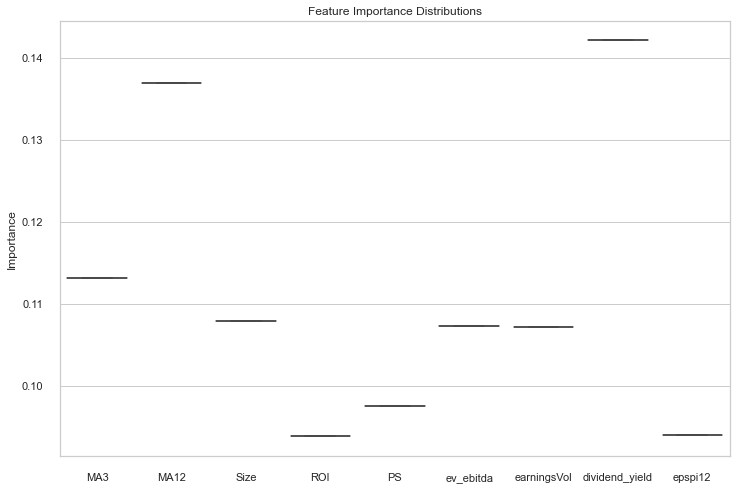

In [31]:
import seaborn as sns
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[rf.feature_importances_ for tree in 
                                     rf],
                               columns=feature_names)

(sns.boxplot(data=all_feat_imp_df)
        .set(title='Feature Importance Distributions',
             ylabel='Importance'));

## ICE

Text(0.5, 0, 'MA12')

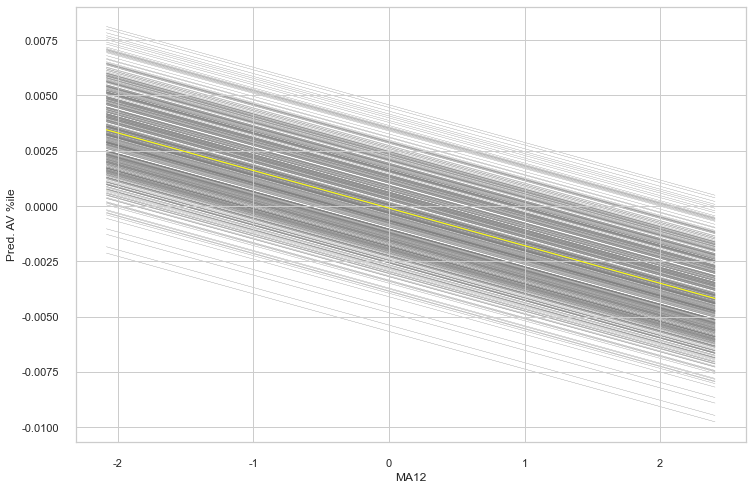

In [25]:
from pycebox.ice import ice, ice_plot
ROE_ice_df = ice(data=X_test, column='MA12', predict=linear.predict)
ice_plot(ROE_ice_df, c='gray',linewidth=0.3,plot_pdp=True,pdp_kwargs={"color":"yellow",'linewidth':1})
plt.ylabel('Pred. AV %ile')
plt.xlabel('MA12')##### One Problem with pycebox.ice:memoryError

Text(0.5, 0, 'MA12')

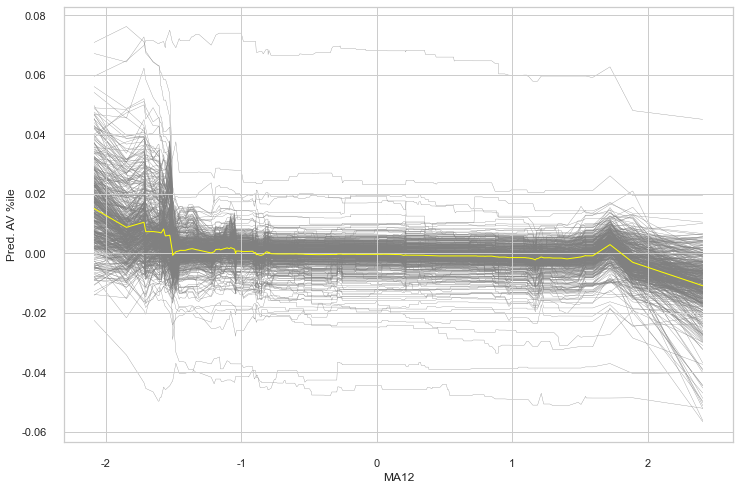

In [26]:
ROE_ice_df = ice(data=X_test, column='MA12', predict=rf.predict)
ice_plot(ROE_ice_df, c='gray',linewidth=0.3,plot_pdp=True,pdp_kwargs={"color":"yellow",'linewidth':1})
plt.ylabel('Pred. AV %ile')
plt.xlabel('MA12')##### One Problem with pycebox.ice:memoryError

## SHAP

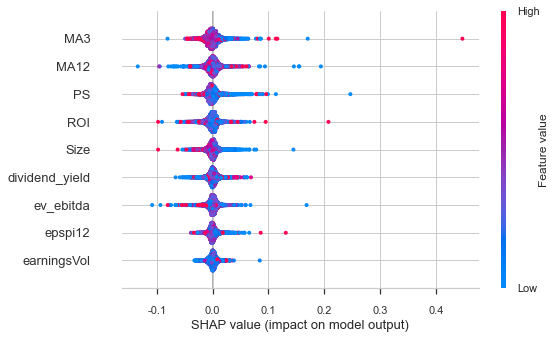

In [6]:
xg_shap = shap.TreeExplainer(xg)
xg_shap_values = xg_shap.shap_values(X_train)
xg_shap_interaction = xg_shap.shap_interaction_values(X_train)
shap.summary_plot(xg_shap_values, X_train)

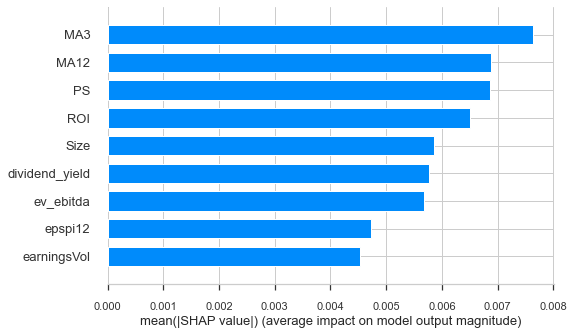

              var  feature_importances_
0             MA3              0.007630
1            MA12              0.006891
4              PS              0.006871
3             ROI              0.006502
2            Size              0.005855
7  dividend_yield              0.005761
5       ev_ebitda              0.005681
8         epspi12              0.004724
6     earningsVol              0.004539


In [7]:
shap.summary_plot(xg_shap_values, X_train, plot_type="bar")
global_shap_values_1 = pd.DataFrame(np.abs(xg_shap_values).mean(0),index=X_train.columns).reset_index()
global_shap_values_1.columns = ['var','feature_importances_']
global_shap_values_1 = global_shap_values_1.sort_values('feature_importances_',ascending=False)
print(global_shap_values_1)

In [8]:
shap.initjs()
def shap_plot(j):
    explainerModel = shap.TreeExplainer(xg)
    shap_values_Model = explainerModel.shap_values(X_train)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_train.iloc[[j]])
    return(p)
shap_plot(0)

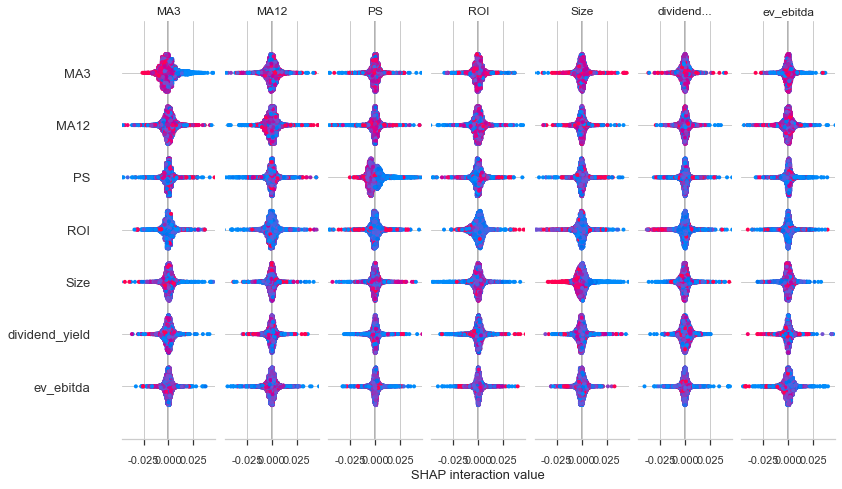

In [9]:
shap.summary_plot(xg_shap_interaction, X_train)

In [10]:
shap.force_plot(xg_shap.expected_value, xg_shap_values, X_train)

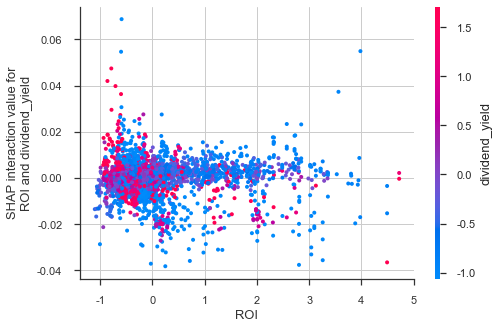

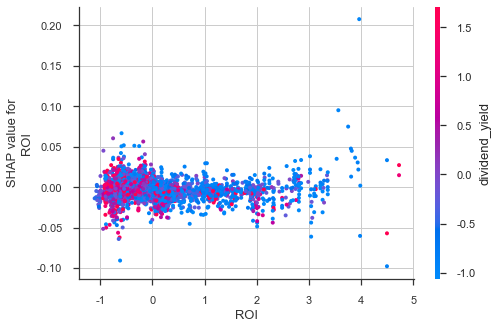

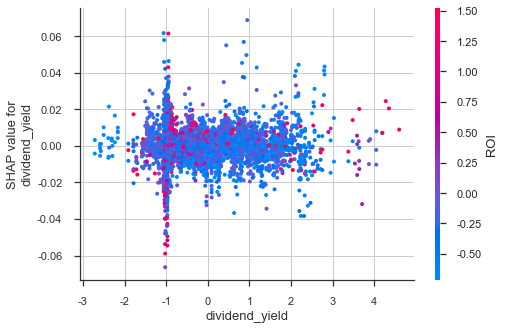

In [11]:
shap.dependence_plot(
    ("ROI", "dividend_yield"),
    xg_shap_interaction, X_train,
    display_features=X_train
)

shap.dependence_plot(3, xg_shap_values, X_train,interaction_index="dividend_yield")
shap.dependence_plot(7, xg_shap_values, X_train,interaction_index="ROI")


In [5]:
for i in feature_names:
    for j in feature_names:
        if i!=j:
            shap.dependence_plot(i, xg_shap_values, X_test, interaction_index=j)
    print("---------------------------------")

NameError: name 'xg_shap_values' is not defined

In [6]:
#################Random Forest##########
rf_shap = shap.TreeExplainer(rf)
rf_shap_values = rf_shap.shap_values(X_train)
rf_shap_interaction = rf_shap.shap_interaction_values(X_train)

In [7]:
feature_names

['MA3',
 'MA12',
 'Size',
 'ROI',
 'PS',
 'ev_ebitda',
 'earningsVol',
 'dividend_yield',
 'epspi12']

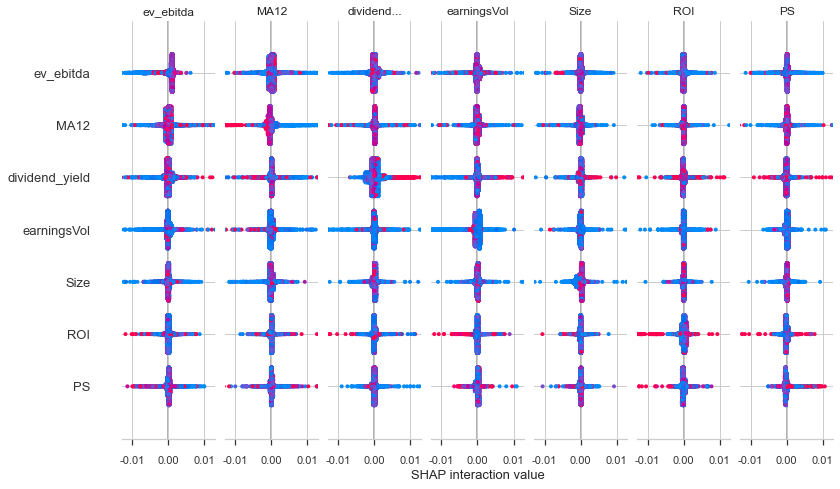

In [12]:
shap.summary_plot(rf_shap_interaction, X_test)

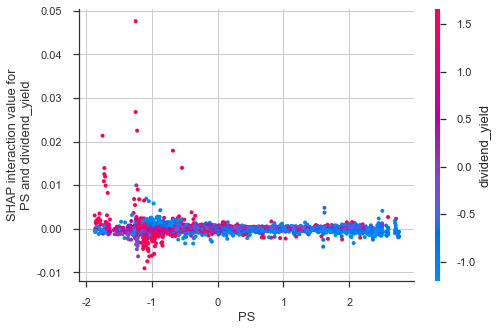

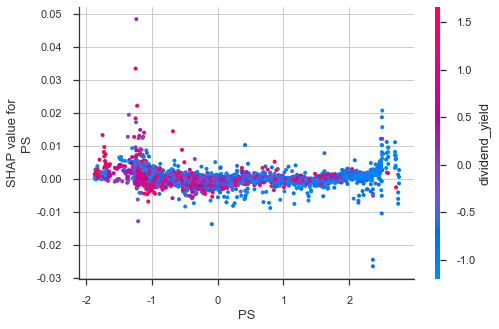

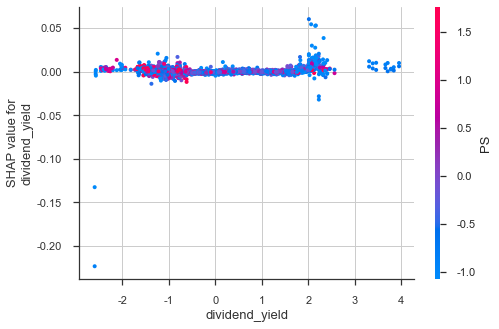

In [10]:
shap.dependence_plot(
    ("PS", "dividend_yield"),
    rf_shap_interaction, X_test,
    display_features = X_test
)

shap.dependence_plot(4, rf_shap_values, X_test,interaction_index="dividend_yield")
shap.dependence_plot(7, rf_shap_values, X_test,interaction_index="PS")

## TOP

In [13]:
train.datadate

0        20171130
1        20171130
2        20171130
3        20171130
4        20171130
           ...   
11764    20191031
11765    20191031
11766    20191031
11767    20191031
11768    20191031
Name: datadate, Length: 11769, dtype: int64

In [6]:
def long_quantile(data):
    return(data[data['pred']>=data['pred'].quantile(0.9)])
    
def short_quantile(data):
    return(data[data['pred']<=data['pred'].quantile(0.1)])
train['pred'] = xg.predict(X_train)
top_train = long_quantile(train)
top_X_train = top_train[feature_names]

bottom_train = short_quantile(train)
bottom_X_train = bottom_train[feature_names]


In [7]:
xg_shap = shap.TreeExplainer(xg)
top_xg_shap_values = xg_shap.shap_values(top_X_train)
top_xg_shap_interaction = xg_shap.shap_interaction_values(top_X_train)

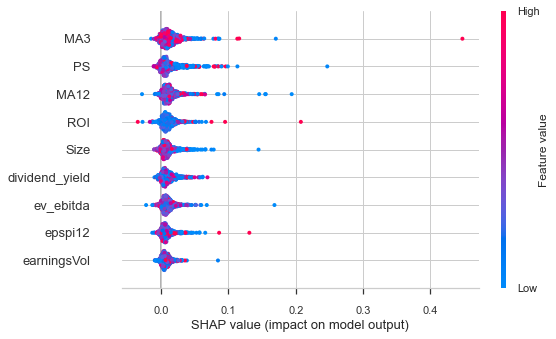

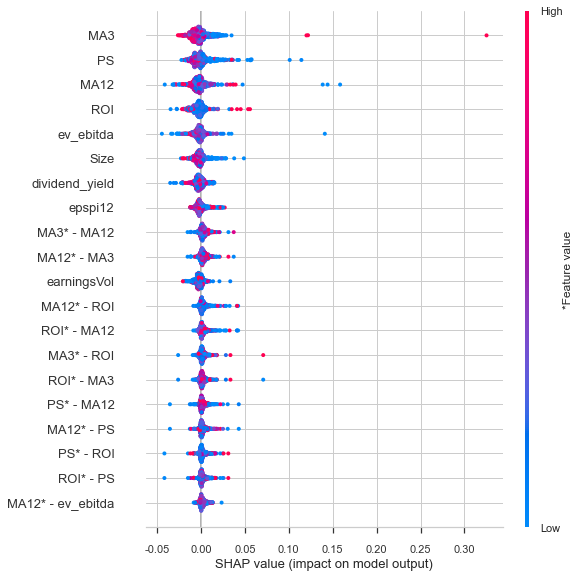

In [14]:
shap.summary_plot(top_xg_shap_values, top_X_train)
shap.summary_plot(top_xg_shap_interaction, top_X_train,plot_type="compact_dot")

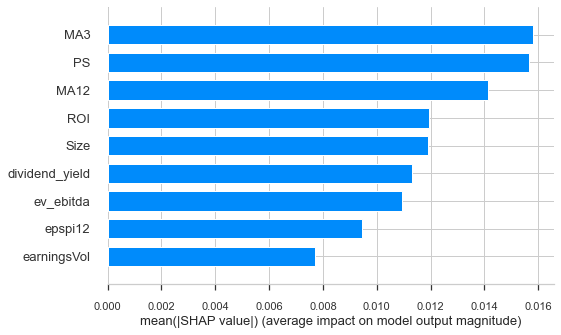

              var  feature_importances_
0             MA3              0.015789
4              PS              0.015642
1            MA12              0.014113
3             ROI              0.011948
2            Size              0.011908
7  dividend_yield              0.011305
5       ev_ebitda              0.010945
8         epspi12              0.009466
6     earningsVol              0.007714


In [19]:
shap.summary_plot(top_xg_shap_values, top_X_train, plot_type="bar")
top_xg_shap_values_1 = pd.DataFrame(np.abs(top_xg_shap_values).mean(0),index=top_X_train.columns).reset_index()
top_xg_shap_values_1.columns = ['var','feature_importances_']
top_xg_shap_values_1 = top_xg_shap_values_1.sort_values('feature_importances_',ascending=False)
print(top_xg_shap_values_1)

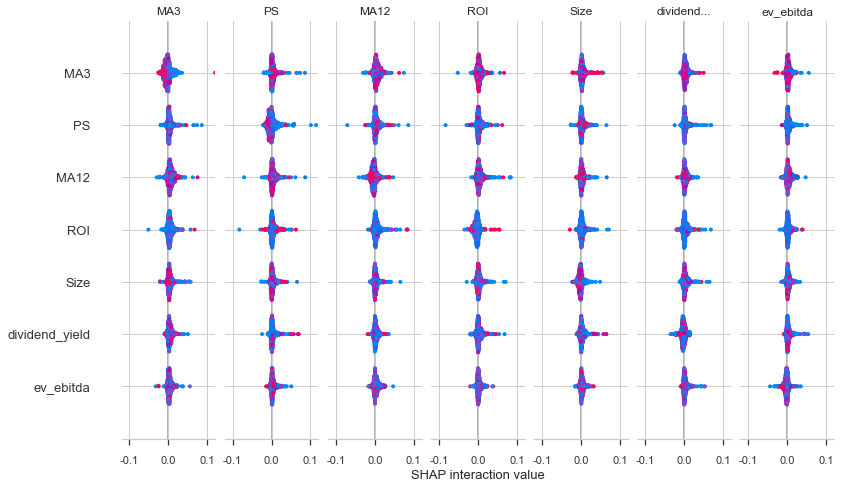

In [20]:
shap.summary_plot(top_xg_shap_interaction, top_X_train, plot_type="bar")

<AxesSubplot:>

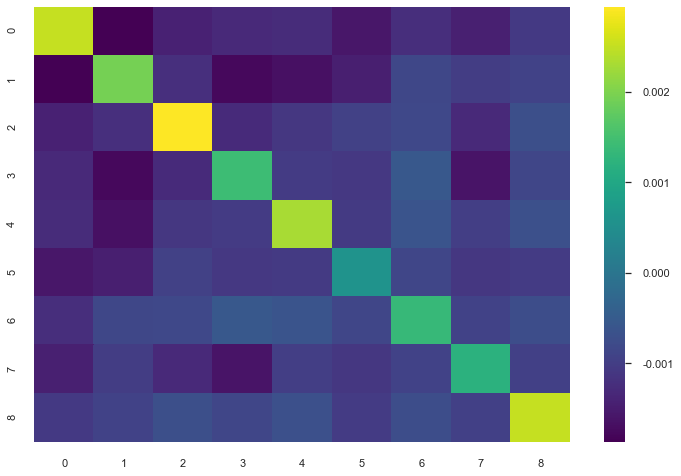

In [94]:
sns.heatmap(np.mean(bottom_xg_shap_interaction,axis=0),cmap = cmap)

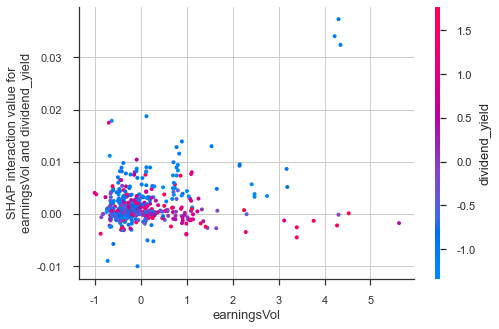

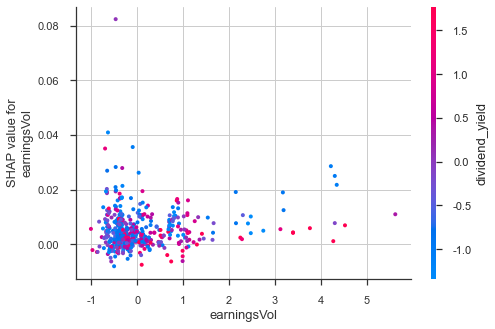

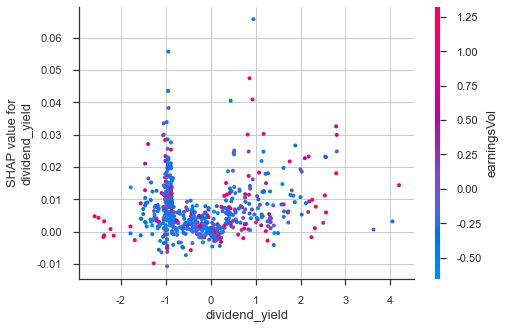

In [33]:
shap.dependence_plot(
    ("earningsVol", "dividend_yield"),
    top_xg_shap_interaction, top_X_train,
    display_features=top_X_train
)

shap.dependence_plot(6, top_xg_shap_values, top_X_train,interaction_index="dividend_yield")
shap.dependence_plot(7, top_xg_shap_values, top_X_train,interaction_index="earningsVol")

In [21]:
shap.initjs()
def shap_plot(j):
    shap_values_Model = xg_shap.shap_values(top_X_train)
    p = shap.force_plot(xg_shap.expected_value, shap_values_Model[j], top_X_train.iloc[[j]])
    return(p)
shap_plot(0)

In [22]:
shap.force_plot(xg_shap.expected_value, top_xg_shap_values, top_X_train)

## Bottom

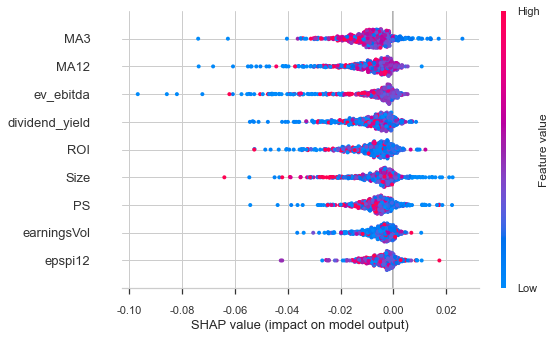

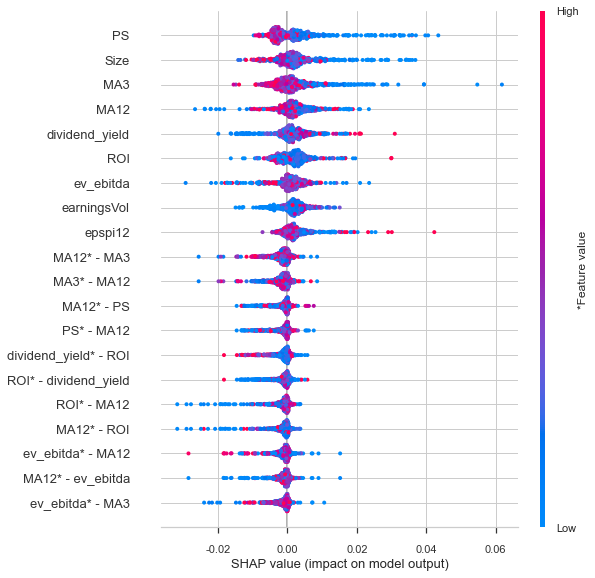

In [51]:
bottom_xg_shap_values = xg_shap.shap_values(bottom_X_train)
bottom_xg_shap_interaction = xg_shap.shap_interaction_values(bottom_X_train)
shap.summary_plot(bottom_xg_shap_values, bottom_X_train)
shap.summary_plot(bottom_xg_shap_interaction, bottom_X_train,plot_type="compact_dot")

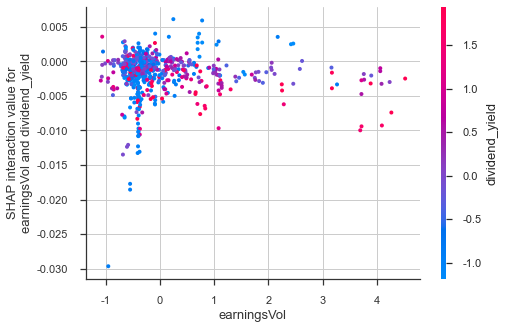

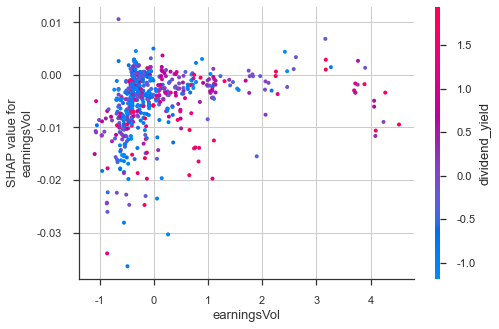

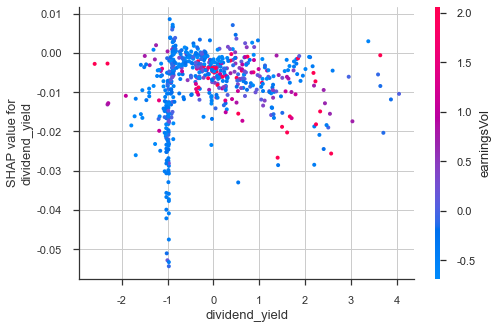

In [39]:
shap.dependence_plot(
    ("earningsVol", "dividend_yield"),
    bottom_xg_shap_interaction, bottom_X_train,
    display_features=bottom_X_train
)

shap.dependence_plot(6, bottom_xg_shap_values, bottom_X_train,interaction_index="dividend_yield")
shap.dependence_plot(7, bottom_xg_shap_values, bottom_X_train,interaction_index="earningsVol")

In [40]:
shap.initjs()
def shap_plot(j):
    shap_values_Model = xg_shap.shap_values(bottom_X_train)
    p = shap.force_plot(xg_shap.expected_value, shap_values_Model[j], bottom_X_train.iloc[[j]])
    return(p)
shap_plot(0)

In [41]:
shap.force_plot(xg_shap.expected_value, bottom_xg_shap_values, bottom_X_train)